In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

In [167]:
company = "IPOE"

twitter_df = pd.read_csv("twitter_data/spac_aggregate.csv")
stock_df = pd.read_csv("stock_data/{}.csv".format(company))

In [168]:
stock_df['% change tomorrow'] = -stock_df[['Close']].pct_change(periods=-1)
stock_df = stock_df.dropna()
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
stock_df.head()

,Date,Open,High,Low,Close,Volume,% change tomorrow
0,2020-12-01,10.60,10.740,10.46,10.60,437500,-0.004739
1,2020-12-02,10.65,10.705,10.40,10.55,318100,-0.012476
2,2020-12-03,10.55,10.560,10.40,10.42,448300,-0.000961
3,2020-12-04,10.65,10.650,10.37,10.41,536500,0.019774
4,2020-12-07,10.69,10.800,10.44,10.62,824200,0.022999


In [169]:
# getting the dates in order
twitter_df["datetime"] = twitter_df[['timestamp']].apply(datetime.fromtimestamp,axis=1)
twitter_df['date'] = twitter_df['datetime'].dt.date

In [170]:
#adding sentiment in
analyzer = SentimentIntensityAnalyzer()
twitter_df["sentiment_scores"] = twitter_df[['text']].apply(analyzer.polarity_scores,axis=1)
twitter_df["sentiment"] = twitter_df[['text']].apply(lambda x: analyzer.polarity_scores(x)['compound'],axis=1)

# Simple analysis

In [171]:
twitter_df = twitter_df[twitter_df['text'].str.contains(company)]

In [172]:
twitter_df.shape

(126, 12)

In [173]:
#this might not be too telling since there has been a lot of spam posts of late 
#(maybe filter to get rid of posts that seem like spam)
filtered_df = twitter_df[(twitter_df['retweets'] >=0) & (twitter_df['likes'] >= 0)]
means = filtered_df[["likes", "retweets", "replies", "sentiment", "date"]].groupby(['date']).mean()
means = means.dropna()

In [174]:
means.shape

(53, 4)

In [175]:
merged = pd.merge(stock_df.set_index('Date'), means, left_index=True, right_index=True)

In [176]:
merged['sentiment'].clip(upper=10000).corr(merged['% change tomorrow'])

0.062228198575376786

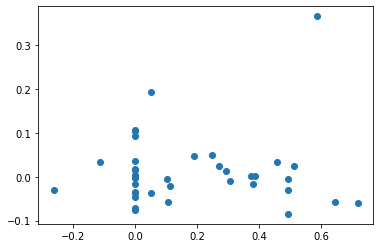

In [177]:
plt.scatter(merged['sentiment'].clip(upper=10000), merged['% change tomorrow'])

# backtesting

In [198]:
money = 100
indices = []
profits = []

for index, row in merged.iterrows():
    if row['likes'] > 25 and row['sentiment'] >= 0:
        profits.append(money*(1+row['% change tomorrow']))
        indices.append(index)
        money *= (1+row['% change tomorrow'])
    elif row['sentiment'] < 0 and row['likes'] > 25:
        profits.append(money/(1+row['% change tomorrow']))
        indices.append(index)
        money /= (1+row['% change tomorrow'])
        pass

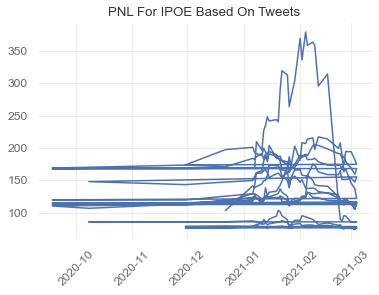

In [199]:
plt.title("PNL For IPOE Based On Tweets")
plt.plot(indices, profits)
plt.xticks(rotation=45)
plt.show()


In [200]:
def create_merged_df(ticker):
    twitter_df = pd.read_csv("twitter_data/spac_aggregate.csv")
    stock_df = pd.read_csv("stock_data/{}.csv".format(ticker))
    
    stock_df['% change tomorrow'] = -stock_df[['Close']].pct_change(periods=-1)
    stock_df = stock_df.dropna()
    stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
    stock_df.head()
    
    # getting the dates in order
    twitter_df["datetime"] = twitter_df[['timestamp']].apply(datetime.fromtimestamp,axis=1)
    twitter_df['date'] = twitter_df['datetime'].dt.date
    
    #adding sentiment in
    analyzer = SentimentIntensityAnalyzer()
    twitter_df["sentiment_scores"] = twitter_df[['text']].apply(analyzer.polarity_scores,axis=1)
    twitter_df["sentiment"] = twitter_df[['text']].apply(lambda x: analyzer.polarity_scores(x)['compound'],axis=1)
    
    twitter_df = twitter_df[twitter_df['text'].str.contains(company)]
    
    #this might not be too telling since there has been a lot of spam posts of late 
    #(maybe filter to get rid of posts that seem like spam)
    filtered_df = twitter_df[(twitter_df['retweets'] >=0) & (twitter_df['likes'] >= 0)]
    means = filtered_df[["likes", "retweets", "replies", "sentiment", "date"]].groupby(['date']).mean()
    means = means.dropna()
    
    merged = pd.merge(stock_df.set_index('Date'), means, left_index=True, right_index=True)
    
    return merged

In [201]:
tickers = ["SPCE", "SOAC", "SNPR", "SHLL", "PSTH", "NOVSU", "JWS", "DKNG", "CLA", "CCIV", "BTAQ", "BFT", "APSG"]
merged = create_merged_df("IPOE")
for ticker in tickers:
    merged = merged.append(create_merged_df(ticker))

In [202]:
merged.tail()

,Open,High,Low,Close,Volume,% change tomorrow,likes,retweets,replies,sentiment,Adj Close
2021-02-25,10.64,10.71,10.305,10.36,1071400,0.012393,56.0,8.0,7.0,0.0000,NaN
2021-02-26,10.32,10.54,10.210,10.49,676800,-0.007685,119.0,15.0,22.0,0.1901,NaN
2021-03-01,10.51,10.59,10.360,10.41,626500,-0.003857,71.0,5.0,3.0,0.4939,NaN
2021-03-03,10.26,10.30,10.080,10.12,531700,-0.000000,68.0,7.0,7.0,0.0000,NaN
2021-03-04,10.10,10.75,10.000,10.12,1640000,-0.003968,48.0,7.0,7.0,0.0000,NaN


In [203]:
merged.index.unique()

Index([2020-12-17, 2020-12-22, 2020-12-30, 2021-01-05, 2021-01-06, 2021-01-07,
       2021-01-08, 2021-01-11, 2021-01-12, 2021-01-13, 2021-01-14, 2021-01-15,
       2021-01-19, 2021-01-20, 2021-01-21, 2021-01-22, 2021-01-25, 2021-01-26,
       2021-01-27, 2021-01-28, 2021-01-29, 2021-02-01, 2021-02-02, 2021-02-04,
       2021-02-05, 2021-02-08, 2021-02-09, 2021-02-11, 2021-02-12, 2021-02-16,
       2021-02-22, 2021-02-23, 2021-02-24, 2021-02-25, 2021-02-26, 2021-03-01,
       2021-03-03, 2021-03-04, 2020-09-18, 2020-10-08, 2020-10-09, 2020-11-11,
       2020-11-30],
      dtype='object')

In [314]:
average_sharpe = 0
trials = 500
for i in range(trials):
    money = 100
    indices = []
    profits = []
    returns = []



    for date in sorted(merged.index.unique()):
        #print(date)
        sub = merged[merged.index == date]
        r = sub.loc[sub['likes'].idxmax()].sample(n=1).iloc[0]
        if r['sentiment'] > .2:
            profits.append(money*(1+r['% change tomorrow']))
            indices.append(date)
            money *= (1+ r['% change tomorrow'])
            returns.append(r['% change tomorrow'])
        elif r['sentiment'] < 0:
            profits.append(money/(1+r['% change tomorrow']))
            indices.append(date)
            money /= (1+r['% change tomorrow'])
            returns.append(1/(1+r['% change tomorrow']) - 1)

    x = pd.DataFrame()
    x['Date'] = indices
    x['Returns'] = returns
    x.set_index('Date')['Returns']
    sharpe = qs.stats.sharpe(x.set_index('Date')['Returns'])
    #print(sharpe)
    average_sharpe += sharpe/trials

In [315]:
print(average_sharpe)

2.0146136287395975


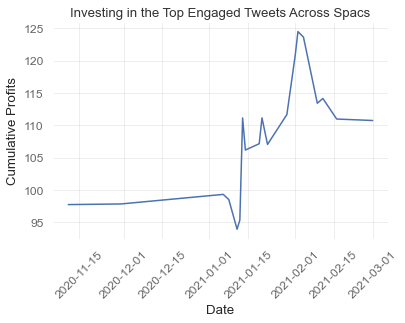

In [316]:
plt.title("Investing in the Top Engaged Tweets Across Spacs")
plt.ylabel("Cumulative Profits")
plt.xlabel("Date")
plt.plot(indices, profits)
plt.xticks(rotation=45)
plt.show()

In [317]:
average_sharpe = 0
trials = 500
for i in range(trials):
    money = 100
    indices = []
    profits = []
    returns = []



    for date in sorted(merged.index.unique()):
        #print(date)
        sub = merged.sample(n=1)  
        r = sub.iloc[0]
        profits.append(money*(1+r['% change tomorrow']))
        indices.append(date)
        money *= (1+ r['% change tomorrow'])
        returns.append(r['% change tomorrow'])


    x = pd.DataFrame()
    x['Date'] = indices
    x['Returns'] = returns
    x.set_index('Date')['Returns']
    sharpe = qs.stats.sharpe(x.set_index('Date')['Returns'])
    #print(sharpe)
    average_sharpe += sharpe/trials

In [318]:
print(average_sharpe)

1.364208328648806


In [ ]:
plt.title("Just Buying a Random Spac")
plt.ylabel("Cumulative Profits")
plt.xlabel("Date")
plt.plot(indices, profits)
plt.xticks(rotation=45)
plt.show()

In [272]:
merged.sample(n=1)

,Open,High,Low,Close,Volume,% change tomorrow,likes,retweets,replies,sentiment,Adj Close
2020-12-17,9.98,10.0,9.945,9.97,1483600,-0.001004,0.0,2.0,0.0,0.0,NaN


In [275]:
x = pd.DataFrame()
x['Date'] = indices
x['Returns'] = returns
x.set_index('Date')['Returns']
qs.stats.sharpe(x.set_index('Date')['Returns'])

1.8001806350992517